## DATA512 - HW1: Professionalism and Reproducibility | AKSHIT MIGLANI

---

## Academy Award Winning Movies: Wikipedia Articles Monthly Traffic Analysis

The primary objective of this project is to scrutinize the monthly Wikipedia page views for Academy Award-winning films. To accomplish this, we leverage the PageViews API, generously provided by Wikimedia, to collect comprehensive data regarding these articles. The API's response furnishes a wealth of information, encompassing the view counts, article titles, access modes (mobile or desktop), and an array of other pertinent details. The data stream from the API spans from July 1, 2015, up to the conclusion of the most recent full month, which, in my particular case, extends until September 30, 2023.

## Data Acquisition

Import python libraries for data acquisition

In [6]:
# Standard python modules
import json, time, urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

In [7]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

In [8]:
# Read the CSV file from which we need the article titles
df_articles = pd.read_csv('../thank_the_academy.AUG.2023.csv')

# Order using article title
df_articles.sort_values(by=['name'], inplace=True)

ARTICLE_TITLES = sorted(df_articles['name'].values)

These are some constants that help make the code a bit more readable.

In [9]:
#    CONSTANTS

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<amiglani@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example below, we only vary the article name, so the majority of the fields
# can stay constant for each request. To make the API fetch data for various access types(desktop,mobile-web,mobile-app and all-access) we create
# different templates as seen below
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",
    "agent":       "user",
    "article":     "",             # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_ALL = {
    "project":     "en.wikipedia.org",
    "access":      "all-access",
    "agent":       "user",
    "article":     "",              # will be taken care of while we call the function
    "granularity": "monthly",
    "start":       "20150701",
    "end":         "20230930"
}

We will initiate the API request through a single procedural approach, designed with reusability in mind. The procedure is parameterized, with the crucial parameters drawing from the constants mentioned above. The fundamental premise is that this procedure will be employed to request data pertaining to a collection of article pages. Consequently, the parameter most susceptible to alteration is the 'article_title.

In [10]:
#    PROCEDURES/FUNCTIONS

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = None,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded and safe is used to avoid interruption to API calls
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe="")
    request_template['article'] = article_title_encoded

    # Creating a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In the forthcoming steps, we will craft lists, each comprising dictionaries that encapsulate information regarding view counts corresponding to specific timestamps and access types for individual articles. Employing the previously defined function, we will invoke the API and subsequently augment our lists with the retrieved data

#### Desktop views

In [11]:
#Creating a list of desktop views for all the articles
desktop_list = []
for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  desktop_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
  try:
    remove_field = 'access'
    #We will now remove the 'access' field from all the dictionaries
    dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in desktop_article['items']]

    #New temp dictionary for making the article name as key
    temp_dict = {}
    for item in dicts_list:
      #Get the value of article key
      article_key = item['article']

      #Remove the article key from the dict
      del item['article']

      #Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      #Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    desktop_list.append(temp_dict)

  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

### Combined mobile views

Given that mobile access is categorized into two segments - website and app - we will combine these segments to construct a unified list that amalgamates both types of views.

In [12]:
#Creating a combined list of views for all mobile accessed articles
mobile_list = []

for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  mobile_web_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
  mobile_app_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)

  try:
    remove_field = 'access'
    # We will now remove the 'access' field from all the dictionaries
    mobile_web_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_web_article['items']]
    mobile_app_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_app_article['items']]

    # Iterate through the individual monthly data and add the monthly views for both web and app access
    for web_entry, app_entry in zip(mobile_web_dicts_list, mobile_app_dicts_list):
      web_entry['views'] = web_entry['views'] + app_entry['views']

    # New temp dictionary for making the article name as key
    temp_dict = {}
    for item in mobile_web_dicts_list:
      # Get the value of article key
      article_key = item['article']

      # Remove the article key from the dict
      del item['article']

      # Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      # Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    mobile_list.append(temp_dict)
  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

### Cumulative views i.e. Desktop+Mobile

In [13]:
# Creating a list of all-access views for all the articles
all_access_list = []
for i in range(0,len(ARTICLE_TITLES)):
  print("Getting pageview data for: ",ARTICLE_TITLES[i])
  cumulatve_article = request_pageviews_per_article(ARTICLE_TITLES[i],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_ALL)
  try:
    remove_field = 'access'
    # We will now remove the 'access' field from all the dictionaries
    all_dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in cumulatve_article['items']]

    # New temp dictionary for making the article name as key
    temp_dict = {}
    for item in all_dicts_list:
      # Get the value of article key
      article_key = item['article']

      # Remove the article key from the dict
      del item['article']

      # Make article as the key of the new dict
      if article_key not in temp_dict:
        temp_dict[article_key] = []
      # Now give the value to the newly created keys
      temp_dict[article_key].append(item)

    all_access_list.append(temp_dict)
  except:
    pass

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

After the formation of our lists - encompassing mobile, desktop, and cumulative data - we will proceed to serialize them into external JSON files. These files will be securely stored within the drive from which we are accessing the dataset

In [15]:
#Path for saving the desktop file
file_path_desktop = "academy_monthly_desktop_start201507_-_end202309.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_desktop, "w") as json_file:
    json.dump(desktop_list, json_file, indent=4)

In [16]:
#Path for saving the mobile file
file_path_mobile = "academy_monthly_mobile_start201507_-_end202309.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_mobile, "w") as json_file:
    json.dump(mobile_list, json_file, indent=4)

In [17]:
#Path for saving the cumulative file
file_path_cumulative = "academy_monthly_cummulative_start201507-end202309.json"

# Open the file in write mode and use json.dump() to write the list to the file
with open(file_path_cumulative, "w") as json_file:
    json.dump(all_access_list, json_file, indent=4)

The ultimate output files take the form of a collection of dictionaries, where each dictionary designates the article name as the primary key. Within these dictionaries, the values consist of a nested list of dictionaries, each characterized by five key-value pairs: 'project,' 'granularity,' 'timestamp,' 'agent,' and 'views.' Notably, 'views' contains integer values, while the remaining keys hold string values. With these files now prepared, our next endeavor entails analysis, where we shall transform the previously constructed list of dictionaries into dataframes.

## Preprocessing and Analysis

Initially, we will undertake the conversion of the lists of dictionaries into dataframes. This process will be applied to all three lists, encompassing desktop, mobile, and cumulative data.

In [18]:
#Creating dataframes from the desktop list
df_desktop = pd.DataFrame()

# Iterate through the data
for entry in desktop_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_desktop = df_desktop.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_desktop = df_desktop[column_order]

In [19]:
#Creating dataframes from the mobile list
df_mobile = pd.DataFrame()

# Iterate through the data
for entry in mobile_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_mobile = df_mobile.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_mobile = df_mobile[column_order]

In [20]:
#Creating dataframes from the cumulative list
df_cumulative = pd.DataFrame()

# Iterate through the data
for entry in all_access_list:
    for article_title, article_data in entry.items():
        for item in article_data:
            item['article'] = article_title  # Add the 'article' column

        # Append the article data to the DataFrame
        df_cumulative = df_cumulative.append(article_data, ignore_index=True)

# Reorder the columns as per your preference (optional)
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
df_cumulative = df_cumulative[column_order]

Removing the 'hours' values (last 2 trailing 0s) as its not needed

In [21]:
# Omit the last two digits from the timestamp which represent the hours. We only need the year, month and date.
df_desktop['timestamp'] = df_desktop['timestamp'].str[:-2]
df_mobile['timestamp'] = df_mobile['timestamp'].str[:-2]
df_cumulative['timestamp'] = df_cumulative['timestamp'].str[:-2]

# Convert the timestamp column to datetime
df_desktop['timestamp'] = pd.to_datetime(df_desktop['timestamp'])
df_mobile['timestamp'] = pd.to_datetime(df_mobile['timestamp'])
df_cumulative['timestamp'] = pd.to_datetime(df_mobile['timestamp'])

We then drop the columns which are not relevant for our analysis

In [22]:
# Drop columns that are not relevant for analysis
df_desktop = df_desktop.drop(columns=['project','granularity','agent'], axis=1)
df_mobile = df_mobile.drop(columns=['project','granularity','agent'], axis=1)
df_cumulative = df_cumulative.drop(columns=['project','granularity','agent'], axis=1)

###  Maximum Average and Minimum Average

This Viz illustrates the time series data for articles exhibiting the highest and lowest average monthly page requests, both in terms of desktop and mobile access.

<Figure size 1500x600 with 0 Axes>

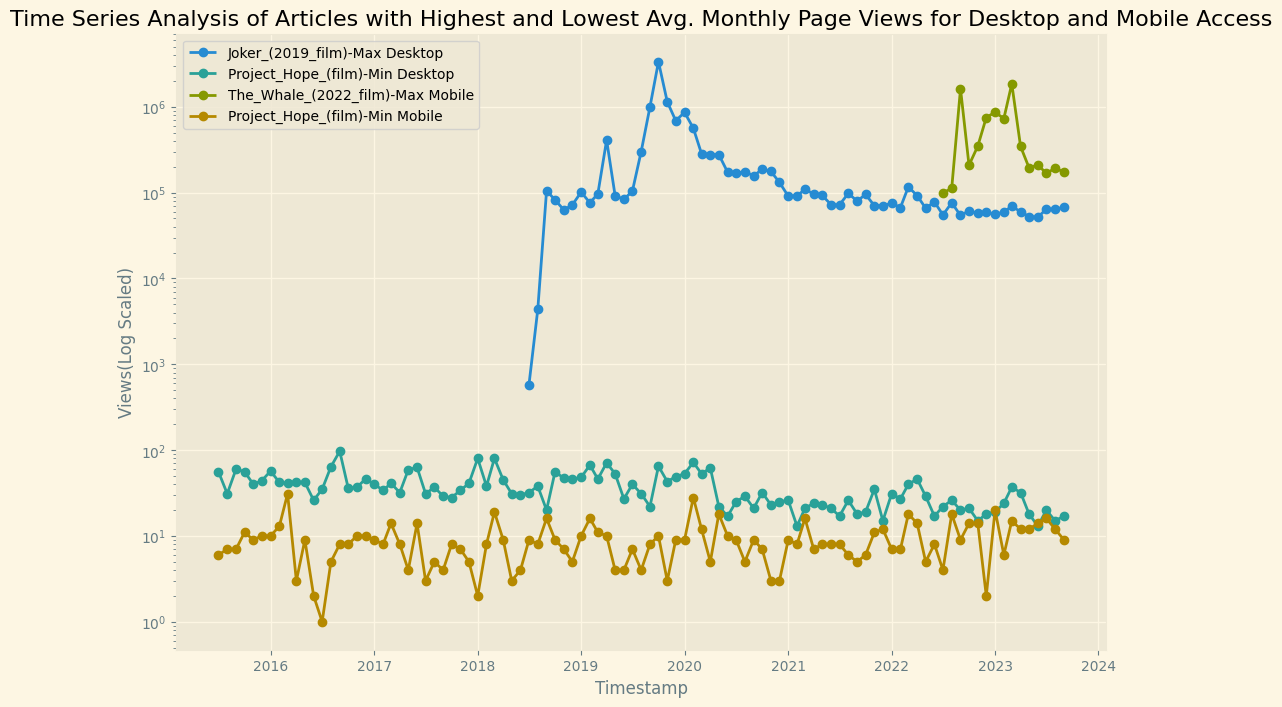

In [23]:
plt.style.use("Solarize_Light2")
plt.figure(figsize=(15, 6))

# Calculate average monthly page requests for each article
desktop_average_data = df_desktop.groupby(['article'])['views'].mean().reset_index()
mobile_average_data = df_mobile.groupby(['article'])['views'].mean().reset_index()


# Identify articles with the highest and lowest average monthly page requests for desktop and mobile
max_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmax()]
min_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmin()]
max_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmax()]
min_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmin()]

# Extract the corresponding monthly data of the four articles from desktop and mobile access dataframes
desktop_highest_data = df_desktop[df_desktop['article']==max_desktop['article']]
desktop_lowest_data = df_desktop[df_desktop['article']==min_desktop['article']]
mobile_highest_data = df_mobile[df_mobile['article']==max_mobile['article']]
mobile_lowest_data = df_mobile[df_mobile['article']==min_mobile['article']]

# Create a line graph
plt.figure(figsize=(12, 8))
label1 = max_desktop['article']
label2 = min_desktop['article']
label3 = max_mobile['article']
label4 = min_mobile['article']


plt.semilogy(desktop_highest_data['timestamp'], desktop_highest_data['views'], label=label1+'-Max Desktop', linestyle='-', marker='o')
plt.semilogy(desktop_lowest_data['timestamp'], desktop_lowest_data['views'], label=label2+'-Min Desktop', linestyle='-', marker='o')
plt.semilogy(mobile_highest_data['timestamp'], mobile_highest_data['views'], label=label3+'-Max Mobile', linestyle='-', marker='o')
plt.semilogy(mobile_lowest_data['timestamp'], mobile_lowest_data['views'], label=label4+'-Min Mobile', linestyle='-', marker='o')

plt.xlabel('Timestamp')
plt.ylabel('Views(Log Scaled)')
plt.title('Time Series Analysis of Articles with Highest and Lowest Avg. Monthly Page Views for Desktop and Mobile Access')
plt.legend()
plt.grid(True)
plt.savefig("../visualizations/AM_max_min_avg_page_req.png")
plt.show()


The analysis brings to light two standout performers in terms of monthly average views: 'Joker (2019)' and 'The Whale (2022).' 'Joker' takes the lead in desktop access, while 'The Whale' claims the top spot in mobile access. It's worth noting that 'The Whale,' being a more recent release, exhibits a shorter data history with occasional spikes in views. In contrast, 'Joker' boasts an extensive data record characterized by a single, substantial peak. On the other end of the spectrum, 'Project Hope' emerges as the lowest-ranking contender in terms of monthly average views for both desktop and mobile access. Its viewership pattern is marked by frequent fluctuations, featuring numerous peaks and troughs.

### (b) Top 10 Peak Page Views

In [24]:
df_sorted_desktop_views = df_desktop.sort_values(by='views',ascending = False).reset_index(drop=True)
df_sorted_mobile_views = df_mobile.sort_values(by='views',ascending = False).reset_index(drop=True)

In [25]:
# Picking out the top 10 articles with the most views for desktop and mobile
df_desktop_top10_views = df_sorted_desktop_views[:10]
df_mobile_top10_views = df_sorted_mobile_views[:10]

In [26]:
# Finding out the months when the articles have peak views
df_desktop_top10_views['peak_month'] = df_desktop_top10_views['timestamp'].apply(lambda x: x.month)
df_mobile_top10_views['peak_month'] = df_mobile_top10_views['timestamp'].apply(lambda x: x.month)

In [27]:
# Retrieve the article names of the top 10 rows which represent the movies with largest page views to check if there are any duplicates
desktop_top10_articles = df_desktop_top10_views['article'].tolist()
mobile_top10_articles = df_mobile_top10_views['article'].tolist()

In [28]:
desktop_top10_articles

['Joker_(2019_film)',
 'Parasite_(2019_film)',
 'Black_Panther_(film)',
 'The_Revenant_(2015_film)',
 'Avatar:_The_Way_of_Water',
 'Spectre_(2015_film)',
 'Dune_(2021_film)',
 '1917_(2019_film)',
 'Tenet_(film)',
 'Blade_Runner_2049']

In [29]:
mobile_top10_articles

['Avatar:_The_Way_of_Water',
 'Joker_(2019_film)',
 'Black_Panther_(film)',
 'Parasite_(2019_film)',
 'Avatar:_The_Way_of_Water',
 'Black_Panther:_Wakanda_Forever',
 'RRR_(film)',
 'Dune_(2021_film)',
 'The_Revenant_(2015_film)',
 'Top_Gun:_Maverick']

It's noticeable that the movie 'Avatar: The Way of Water' makes a recurring appearance in the Top 10 list for mobile access. Operating under the assumption that movie names should be distinct, the subsequent step involves selecting the top 10 unique movie entries for the mobile access category.

In [30]:
# Retrieve the Top 10 unique articles and the month for each article that contains the highest page views
mobile_top10 = df_sorted_mobile_views.drop_duplicates(['article']).head(10)
mobile_top10['peak_month'] = mobile_top10['timestamp'].apply(lambda x: x.month)

In [31]:
#Retrieving the name of the top 10 mobile accessed articles again. These won't have any duplicates
mobile_top10_articles = mobile_top10['article'].tolist()
mobile_top10_articles

['Avatar:_The_Way_of_Water',
 'Joker_(2019_film)',
 'Black_Panther_(film)',
 'Parasite_(2019_film)',
 'Black_Panther:_Wakanda_Forever',
 'RRR_(film)',
 'Dune_(2021_film)',
 'The_Revenant_(2015_film)',
 'Top_Gun:_Maverick',
 'Everything_Everywhere_All_at_Once']

<Figure size 1500x600 with 0 Axes>

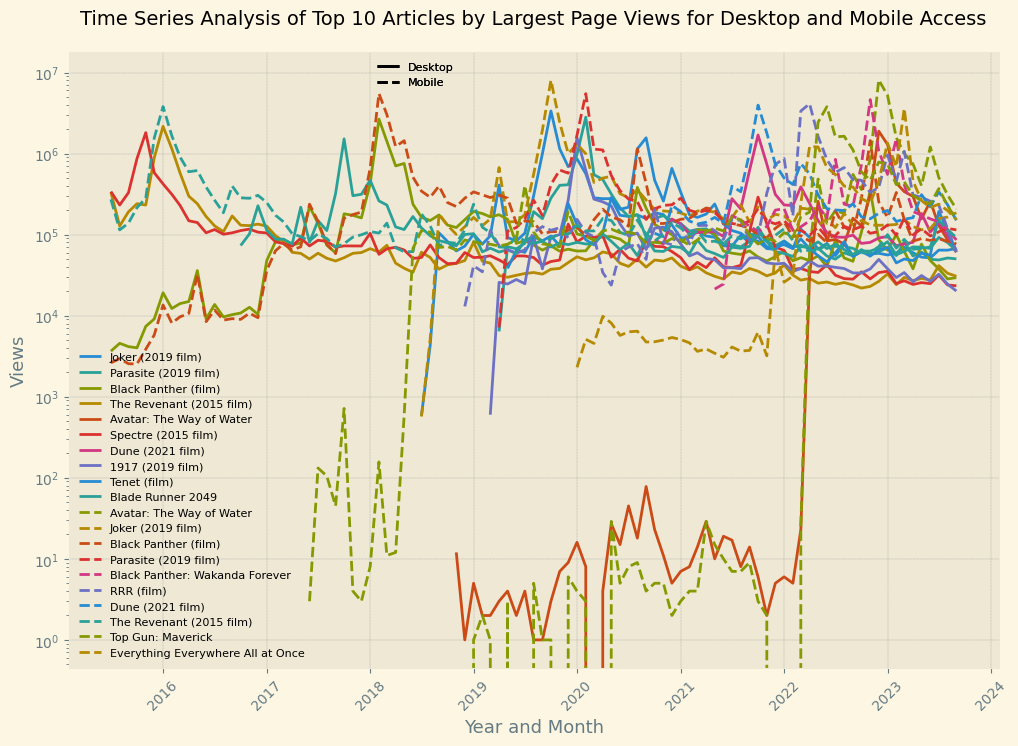

In [32]:
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

plt.style.use("Solarize_Light2")
plt.figure(figsize=(15, 6))

# Create a figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Iterate through all the articles in desktop and mobile to plot the views as a timeseries graph
for desktop_article in desktop_top10_articles:
    desktop_article_result = df_desktop[df_desktop['article'] == desktop_article]
    ax.plot(desktop_article_result['timestamp'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_', ' '))

for mobile_article in mobile_top10_articles:
    mobile_article_result = df_mobile[df_mobile['article'] == mobile_article]
    ax.plot(mobile_article_result['timestamp'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_', ' '))

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Analysis of Top 10 Articles by Largest Page Views for Desktop and Mobile Access', pad=20,
          fontsize=14)

# The first legend below represents all the article names
legend1 = plt.legend(loc='lower left', prop={"size": 8}, frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 1), prop={"size": 8},
                    frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.savefig(r"../visualizations/AM_top_10_peak_page_views.png")
plt.show()


The chart above exhibits twenty line graphs, representing the Top 10 articles with the highest page views for both desktop and mobile platforms. Notably, the peaks in the mobile views surpass those of the desktop views. An intriguing pattern emerges as these peaks cluster into approximately four distinct groups, adding an element of intrigue to the analysis.

### (c) Fewest Months of Data

The final graph accentuates pages characterized by their limited data history, spanning across both desktop and mobile access categories. These pages showcase relatively concise time series, capturing some of the most recent Academy Award-winning content.

<Figure size 1500x600 with 0 Axes>

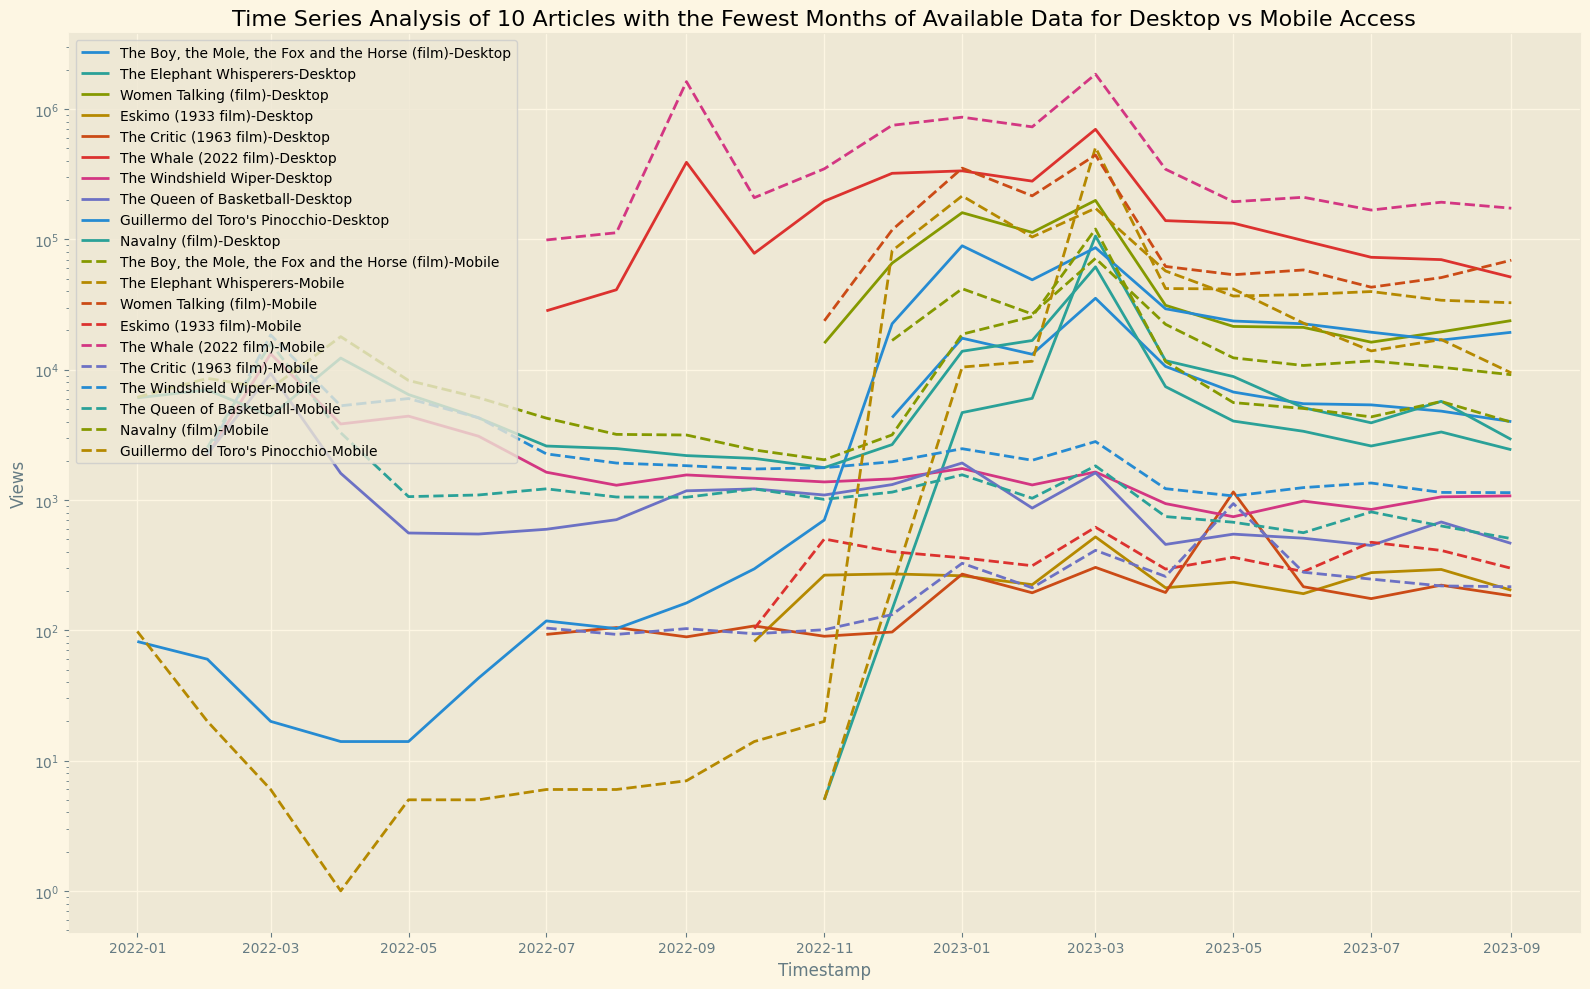

In [33]:
plt.style.use("Solarize_Light2")
plt.figure(figsize=(15, 6))

# Group by article and access, and count the number of unique months
article_counts_desktop = df_desktop.groupby(['article'])['timestamp'].nunique().reset_index()
article_counts_mobile = df_mobile.groupby(['article'])['timestamp'].nunique().reset_index()

# Sort by the number of unique months
article_counts_desktop = article_counts_desktop.sort_values(by='timestamp')
article_counts_mobile = article_counts_mobile.sort_values(by='timestamp')

# Get the 10 articles with the fewest months of data for desktop and mobile access
desktop_articles_least_10 = article_counts_desktop[:10]
mobile_articles_least_10 = article_counts_mobile[:10]

# Create line charts for the selected articles
plt.figure(figsize=(16, 10))

for index, row in desktop_articles_least_10.iterrows():
    article_data = df_desktop[(df_desktop['article'] == row['article'])]
    plt.semilogy(article_data['timestamp'], article_data['views'], linestyle='-',
            label=desktop_articles_least_10['article'][index].replace('_',' ')+'-Desktop')

for index, row in mobile_articles_least_10.iterrows():
    article_data = df_mobile[(df_mobile['article'] == row['article'])]
    plt.semilogy(article_data['timestamp'], article_data['views'], linestyle='--',
            label=mobile_articles_least_10['article'][index].replace('_',' ')+'-Mobile')

plt.title('Time Series Analysis of 10 Articles with the Fewest Months of Available Data for Desktop vs Mobile Access')
plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig("../visualizations/fewest_months_data.png")
plt.show()


# Conclusion

In summary, we have created three graphical representations utilizing monthly traffic data for English Wikipedia articles related to Academy Award-winning films. The dataset covers the period from July 1, 2015, to September 30, 2023, offering insights into data trends and patterns.

- The first graph explored the time series dynamics of articles, ranging from those with the highest to the lowest average monthly page requests for both desktop and mobile access. 'Joker (2019)' emerged as the leader in monthly average views for desktop access, while 'The Whale (2022)' claimed the top position for mobile access. Conversely, 'Project Hope' exhibited the lowest monthly average views for both access types.

- The second graph showcased time series data for the top 10 articles with the highest page views, categorized by access type. Notably, mobile views consistently outshone desktop views in terms of peaks, with these peaks forming roughly four discernible clusters.

- The third graph cast a spotlight on articles with relatively brief data histories, encompassing both desktop and mobile access. These line graphs depicted concise time series data, predominantly revolving around recent Academy Award-winning content. Interestingly, a similar trend was observed across articles for both mobile and desktop views.

---